In [1]:
# Import dependencies
import nibabel as nib
import numpy as np
import cv2
import scipy.io
import os
import imageio
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
sys.path.append("..")
from utils_l import *

In [2]:
root_dir="../data"
SAMPLE_NAME= "DBS_bG01"
SAMPLE_PATH = f"../data/{SAMPLE_NAME}"
#NIFTI_PATH = study_paths[0]
nifti = nib.load(SAMPLE_PATH)
nifti_data = np.nan_to_num(np.array(nifti.get_fdata()))
GT = np.load(os.path.join(SAMPLE_PATH,"pin_tips.npy"))
GT = from_hull_to_ct_coords(GT, nifti)

ImageFileError: Cannot work out file type of "../data/DBS_bG01"

In [ ]:
point_cloud = np.array([0,0,0])
for i in range(nifti_data.shape[1]):
    img = nifti_data[:,i,:]
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    white_pixels = img>0.9
    white_pixel_coords = np.array(np.where(white_pixels == 1)).transpose(1,0)
    point_cloud = np.vstack((point_cloud, np.hstack( (white_pixel_coords, np.ones((white_pixel_coords.shape[0] , 1))*i ))))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2], )
ax.scatter3D(GT[:,0], GT[:,1], GT[:,2], c='r',s=40)

In [ ]:
GT

In [ ]:
labels = labels.squeeze()

In [ ]:
#Display the segmented features on CT volume
from mayavi import mlab
mlab.init_notebook()
fig = mlab.figure(bgcolor=(1, 1, 1), size=(500, 500))
source_1 = mlab.pipeline.scalar_field(nifti_data)
surface = mlab.pipeline.iso_surface(source_1, 
                         contours=[256,], 
                         opacity=0.5, 
                         colormap = 'black-white')
surface
mlab.points3d(labels[:,0],labels[:,1],labels[:,2], color = (0.2,1,.2), scale_factor=10)


# DATA

In [3]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import nibabel as nib
from scipy import ndimage

In [4]:
def read_nifti_file(filepath):
    """Read and load volume"""

    return scan


In [5]:
def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

In [6]:
def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 64
    desired_height = 64
    
    # Compute depth factor
    f0 = desired_width /  img.shape[0]
    f1 = desired_height /  img.shape[1]
    f2 = desired_depth /   img.shape[2]

    img = ndimage.zoom(img, (f0, f1, f2), order=1)
    return img, f0, f1,f2

In [67]:
def sort_points_by_distance_from_origin(points):
    """
        Args:
            points 4x3
    """
    keys = np.argsort(np.linalg.norm(points,axis=1))
    return points[keys]

In [157]:
def process_study(path):
    """Read and resize volume"""
    
    ct_path = os.path.join(path, "preop_ct.nii")
    pins_path =  os.path.join(path, "pin_tips.npy")
    
    nifti = nib.load(ct_path)
    nifti_data = np.nan_to_num(np.array(nifti.get_fdata()))
    coords = np.load(pins_path)
    coords = from_hull_to_ct_coords(coords, nifti).squeeze()    
    # Normalize
    volume = normalize(nifti_data)
    
    # Resize width, height and depth
    volume, f0, f1, f2 = resize_volume(volume)
    
    coords[:,0]*=f0
    coords[:,1]*=f1
    coords[:,2]*=f2
    
    coords = sort_points_by_distance_from_origin(coords)
    
    #mask = np.zeros_like(volume)
    #for c in coords:
    #    mask[ int(c[0]), int(c[1]), int(c[2])]=1
    # divide b 60 to normalize
    return volume, coords/60, [f0,f1,f2]

In [72]:
DATA_PATH = "C:/Users/VukadinoviM/Documents/BrainReg/data"
study_paths = []
for study in os.listdir(DATA_PATH):
    if (os.path.exists(os.path.join(DATA_PATH, study, "preop_ct.nii")) and  
       os.path.exists(p:= os.path.join(DATA_PATH, study, "pin_tips.npy")) and
       np.load(p).shape[0]==4):
        study_paths.append(os.path.join(DATA_PATH, study))

In [73]:
scans = [] 
labels = []

for path in study_paths:
    s,l = process_study(path)
    scans.append(s)
    labels.append(l)
    
scans = np.array(scans)
labels = np.array(labels)

In [74]:
x_train=scans[:60]
y_train=labels[:60]

x_val=scans[60:]
y_val=labels[60:]

In [75]:
y_val[0].shape

(4, 3)

In [194]:
x_train.shape

(60, 64, 64, 64)

In [197]:
y_train.shape

(60, 4, 3)

### INSERT DATA AUGMENTATION

In [76]:
import random
@tf.function
def rotate_img(volume):
    """Rotate the volume by a few degrees"""
    
    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        
        # pick angles at random
        angle=random.choice(angles)
        
        #rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume<0]=0
        volume[volume>1]=1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

In [77]:
def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
#   volume,mask = rotate(volume,mask)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


In [78]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [79]:
batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

# MODEL

In [81]:
def get_model(width=64, height=64, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(units=12, activation="sigmoid")(x)
    out = layers.Reshape((4,3))(x)
    
    # Define the model.
    model = keras.Model(inputs, out, name="3dcnn")
    return model


# Build model.
model = get_model(width=64, height=64, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 64, 1)]   0         
                                                                 
 conv3d_8 (Conv3D)           (None, 62, 62, 62, 64)    1792      
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 31, 31, 31, 64)   0         
 3D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 31, 31, 31, 64)   256       
 hNormalization)                                                 
                                                                 
 conv3d_9 (Conv3D)           (None, 29, 29, 29, 64)    110656    
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 14, 14, 14, 64)   0     

## TODO:

In [82]:
def euc_dist_tf (y_true, y_pred):
    """
        Args:
            y_true tf tensor (batch_size, 4,3) 
            y_pred tf tensor (batch_size, 4,3)
    """
    return tf.math.reduce_mean(tf.math.reduce_euclidean_norm(y_true-y_pred, axis=-1))
# def euc_dist(y_true, y_pred):
    
#     truth = np.array(np.where(y_true==1)).transpose(0,2,1)
#     preds = get_four_max_points(y_pred)
#     return euclidean_distance_coords(preds, truth)
#def euc_dist_tf(y_true, ypred):
    #truth = tf.cast(get_four_max_points_tensor(y_true), tf.float32)
    #preds = tf.cast(get_four_max_points_tensor(ypred), tf.float32)
    # TODO ADD INVARIANT EUCLIDEAN DISANCE
#    return tf.math.reduce_mean(preds-truth)

In [83]:
import tensorflow as tf

def get_four_max_points_tensor(array):
    """
    Function to get four max points of a 3d tensor
    Args
        array tf.Tensor float
    Returns
        four_max_points tf.Tensor float
    """
    return tf.transpose(tf.unravel_index(tf.nn.top_k(tf.reshape(array, [-1]),4).indices,[64,64,64]),[1,0])


class EuclideanDistance(keras.metrics.Metric):
    
    def __init__(self, name="ed", **kwargs):
        super().__init__(name=name, **kwargs)
        
        self.ed_sum = self.add_weight(name="ed_sum",
                                      initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros",
            dtype="int32")
        
    def update_state(self, y_true, y_pred, sample_weight=None):

        ed = euc_dist_tf(y_true, y_pred)
        self.ed_sum.assign_add(ed)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)
        
    def result(self):
        return self.ed_sum / tf.cast(self.total_samples, tf.float32)
    def reset_state(self):
        self.ed_sum.assign(0.)
        self.total_samples.assign(0)

In [84]:
b = tf.keras.losses.BinaryCrossentropy()
b(tf.zeros((64,64,64)), tf.zeros((64,64,64)))

<tf.Tensor: shape=(), dtype=float32, numpy=-0.0>

In [85]:
# Compile model.
initial_learning_rate = 0.0001

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

model.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=EuclideanDistance(),
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)

#early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 400
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb] #early_stopping_cb],
)

Epoch 1/400
30/30 - 3s - loss: 0.0415 - ed: 0.1716 - val_loss: 0.0296 - val_ed: 0.1467 - 3s/epoch - 107ms/step
Epoch 2/400
30/30 - 2s - loss: 0.0221 - ed: 0.1203 - val_loss: 0.0059 - val_ed: 0.0601 - 2s/epoch - 77ms/step
Epoch 3/400
30/30 - 2s - loss: 0.0127 - ed: 0.0871 - val_loss: 0.0100 - val_ed: 0.0819 - 2s/epoch - 75ms/step
Epoch 4/400
30/30 - 2s - loss: 0.0124 - ed: 0.0827 - val_loss: 0.0240 - val_ed: 0.1308 - 2s/epoch - 75ms/step
Epoch 5/400
30/30 - 2s - loss: 0.0107 - ed: 0.0796 - val_loss: 0.0283 - val_ed: 0.1433 - 2s/epoch - 76ms/step
Epoch 6/400
30/30 - 2s - loss: 0.0111 - ed: 0.0770 - val_loss: 0.0349 - val_ed: 0.1586 - 2s/epoch - 79ms/step
Epoch 7/400
30/30 - 3s - loss: 0.0105 - ed: 0.0740 - val_loss: 0.0421 - val_ed: 0.1742 - 3s/epoch - 85ms/step
Epoch 8/400
30/30 - 3s - loss: 0.0097 - ed: 0.0717 - val_loss: 0.0423 - val_ed: 0.1754 - 3s/epoch - 85ms/step
Epoch 9/400
30/30 - 3s - loss: 0.0089 - ed: 0.0682 - val_loss: 0.0431 - val_ed: 0.1754 - 3s/epoch - 85ms/step
Epoch 10/

Epoch 75/400
30/30 - 3s - loss: 0.0032 - ed: 0.0380 - val_loss: 0.0044 - val_ed: 0.0542 - 3s/epoch - 86ms/step
Epoch 76/400
30/30 - 2s - loss: 0.0031 - ed: 0.0379 - val_loss: 0.0031 - val_ed: 0.0449 - 2s/epoch - 82ms/step
Epoch 77/400
30/30 - 2s - loss: 0.0028 - ed: 0.0361 - val_loss: 0.0036 - val_ed: 0.0469 - 2s/epoch - 82ms/step
Epoch 78/400
30/30 - 2s - loss: 0.0036 - ed: 0.0392 - val_loss: 0.0045 - val_ed: 0.0497 - 2s/epoch - 82ms/step
Epoch 79/400
30/30 - 2s - loss: 0.0029 - ed: 0.0368 - val_loss: 0.0044 - val_ed: 0.0496 - 2s/epoch - 81ms/step
Epoch 80/400
30/30 - 2s - loss: 0.0031 - ed: 0.0387 - val_loss: 0.0052 - val_ed: 0.0546 - 2s/epoch - 82ms/step
Epoch 81/400
30/30 - 2s - loss: 0.0035 - ed: 0.0386 - val_loss: 0.0054 - val_ed: 0.0583 - 2s/epoch - 82ms/step
Epoch 82/400
30/30 - 2s - loss: 0.0033 - ed: 0.0416 - val_loss: 0.0041 - val_ed: 0.0494 - 2s/epoch - 82ms/step
Epoch 83/400
30/30 - 2s - loss: 0.0026 - ed: 0.0354 - val_loss: 0.0042 - val_ed: 0.0491 - 2s/epoch - 82ms/step
E

Epoch 149/400
30/30 - 3s - loss: 0.0021 - ed: 0.0311 - val_loss: 0.0036 - val_ed: 0.0473 - 3s/epoch - 84ms/step
Epoch 150/400
30/30 - 2s - loss: 0.0022 - ed: 0.0309 - val_loss: 0.0029 - val_ed: 0.0418 - 2s/epoch - 81ms/step
Epoch 151/400
30/30 - 3s - loss: 0.0020 - ed: 0.0310 - val_loss: 0.0038 - val_ed: 0.0483 - 3s/epoch - 84ms/step
Epoch 152/400
30/30 - 3s - loss: 0.0021 - ed: 0.0304 - val_loss: 0.0027 - val_ed: 0.0418 - 3s/epoch - 84ms/step
Epoch 153/400
30/30 - 3s - loss: 0.0029 - ed: 0.0309 - val_loss: 0.0034 - val_ed: 0.0470 - 3s/epoch - 84ms/step
Epoch 154/400
30/30 - 2s - loss: 0.0023 - ed: 0.0299 - val_loss: 0.0040 - val_ed: 0.0510 - 2s/epoch - 83ms/step
Epoch 155/400
30/30 - 2s - loss: 0.0022 - ed: 0.0298 - val_loss: 0.0056 - val_ed: 0.0593 - 2s/epoch - 80ms/step
Epoch 156/400
30/30 - 2s - loss: 0.0024 - ed: 0.0313 - val_loss: 0.0037 - val_ed: 0.0465 - 2s/epoch - 81ms/step
Epoch 157/400
30/30 - 2s - loss: 0.0025 - ed: 0.0329 - val_loss: 0.0033 - val_ed: 0.0444 - 2s/epoch - 81

Epoch 223/400
30/30 - 2s - loss: 0.0028 - ed: 0.0293 - val_loss: 0.0030 - val_ed: 0.0442 - 2s/epoch - 81ms/step
Epoch 224/400
30/30 - 2s - loss: 0.0027 - ed: 0.0312 - val_loss: 0.0042 - val_ed: 0.0530 - 2s/epoch - 82ms/step
Epoch 225/400
30/30 - 3s - loss: 0.0028 - ed: 0.0317 - val_loss: 0.0049 - val_ed: 0.0564 - 3s/epoch - 87ms/step
Epoch 226/400
30/30 - 3s - loss: 0.0021 - ed: 0.0282 - val_loss: 0.0038 - val_ed: 0.0499 - 3s/epoch - 88ms/step
Epoch 227/400
30/30 - 3s - loss: 0.0025 - ed: 0.0294 - val_loss: 0.0030 - val_ed: 0.0438 - 3s/epoch - 85ms/step
Epoch 228/400
30/30 - 3s - loss: 0.0025 - ed: 0.0293 - val_loss: 0.0027 - val_ed: 0.0416 - 3s/epoch - 86ms/step
Epoch 229/400
30/30 - 3s - loss: 0.0022 - ed: 0.0276 - val_loss: 0.0030 - val_ed: 0.0450 - 3s/epoch - 84ms/step
Epoch 230/400
30/30 - 3s - loss: 0.0022 - ed: 0.0292 - val_loss: 0.0027 - val_ed: 0.0417 - 3s/epoch - 84ms/step
Epoch 231/400
30/30 - 3s - loss: 0.0017 - ed: 0.0260 - val_loss: 0.0022 - val_ed: 0.0375 - 3s/epoch - 84

Epoch 297/400
30/30 - 2s - loss: 0.0016 - ed: 0.0242 - val_loss: 0.0021 - val_ed: 0.0360 - 2s/epoch - 83ms/step
Epoch 298/400
30/30 - 2s - loss: 0.0018 - ed: 0.0256 - val_loss: 0.0019 - val_ed: 0.0345 - 2s/epoch - 83ms/step
Epoch 299/400
30/30 - 2s - loss: 0.0019 - ed: 0.0261 - val_loss: 0.0026 - val_ed: 0.0396 - 2s/epoch - 83ms/step
Epoch 300/400
30/30 - 2s - loss: 0.0016 - ed: 0.0258 - val_loss: 0.0039 - val_ed: 0.0482 - 2s/epoch - 83ms/step
Epoch 301/400
30/30 - 2s - loss: 0.0017 - ed: 0.0253 - val_loss: 0.0029 - val_ed: 0.0411 - 2s/epoch - 83ms/step
Epoch 302/400
30/30 - 2s - loss: 0.0019 - ed: 0.0262 - val_loss: 0.0041 - val_ed: 0.0506 - 2s/epoch - 82ms/step
Epoch 303/400
30/30 - 2s - loss: 0.0021 - ed: 0.0267 - val_loss: 0.0024 - val_ed: 0.0379 - 2s/epoch - 80ms/step
Epoch 304/400
30/30 - 2s - loss: 0.0017 - ed: 0.0276 - val_loss: 0.0038 - val_ed: 0.0490 - 2s/epoch - 82ms/step
Epoch 305/400
30/30 - 3s - loss: 0.0018 - ed: 0.0270 - val_loss: 0.0026 - val_ed: 0.0395 - 3s/epoch - 83

Epoch 371/400
30/30 - 2s - loss: 0.0017 - ed: 0.0234 - val_loss: 0.0026 - val_ed: 0.0393 - 2s/epoch - 83ms/step
Epoch 372/400
30/30 - 3s - loss: 0.0023 - ed: 0.0261 - val_loss: 0.0028 - val_ed: 0.0392 - 3s/epoch - 84ms/step
Epoch 373/400
30/30 - 3s - loss: 0.0017 - ed: 0.0229 - val_loss: 0.0026 - val_ed: 0.0386 - 3s/epoch - 84ms/step
Epoch 374/400
30/30 - 3s - loss: 0.0019 - ed: 0.0237 - val_loss: 0.0021 - val_ed: 0.0348 - 3s/epoch - 84ms/step
Epoch 375/400
30/30 - 3s - loss: 0.0019 - ed: 0.0258 - val_loss: 0.0020 - val_ed: 0.0347 - 3s/epoch - 84ms/step
Epoch 376/400
30/30 - 3s - loss: 0.0018 - ed: 0.0241 - val_loss: 0.0018 - val_ed: 0.0318 - 3s/epoch - 84ms/step
Epoch 377/400
30/30 - 3s - loss: 0.0018 - ed: 0.0252 - val_loss: 0.0022 - val_ed: 0.0357 - 3s/epoch - 84ms/step
Epoch 378/400
30/30 - 3s - loss: 0.0020 - ed: 0.0249 - val_loss: 0.0020 - val_ed: 0.0355 - 3s/epoch - 84ms/step
Epoch 379/400
30/30 - 3s - loss: 0.0016 - ed: 0.0243 - val_loss: 0.0023 - val_ed: 0.0380 - 3s/epoch - 84

## TRAINING

In [90]:
model.history.history.keys()

dict_keys(['loss', 'ed', 'val_loss', 'val_ed'])

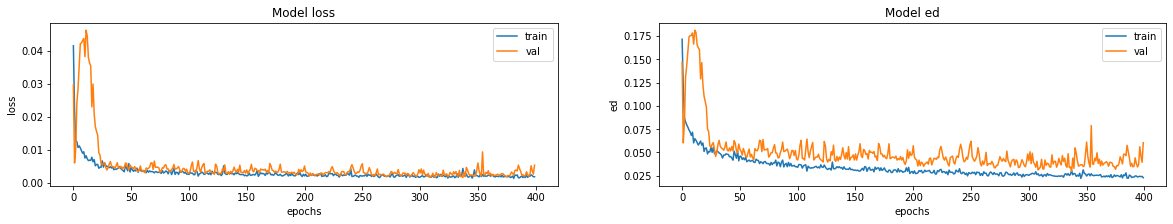

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["loss", "ed"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


# Inference

In [185]:
study_path = "../data/DBS_bG01"
ct_path = os.path.join(study_path, "preop_ct.nii")
nifti = nib.load(ct_path)
nifti_data = np.nan_to_num(np.array(nifti.get_fdata()))

ct_ex, label_ex, factors = process_study(study_path)
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(ct_ex, axis=0))[0]

1/1 [==============================] - 0s 29ms/step


In [186]:
factors = 1/np.array(factors)
label_ex[:,0]*=factors[0]
label_ex[:,1]*=factors[1]
label_ex[:,2]*=factors[2]
prediction[:,0]*=factors[0]
prediction[:,1]*=factors[1]
prediction[:,2]*=factors[2]

Unnormalize and unscale

In [187]:
prediction *= 60
label_ex *= 60

In [188]:
#Display the segmented features on CT volume
from mayavi import mlab
mlab.init_notebook()
fig = mlab.figure(bgcolor=(1, 1, 1), size=(500, 500))
source_1 = mlab.pipeline.scalar_field(nifti_data)
surface = mlab.pipeline.iso_surface(source_1, 
                         contours=[0.9,], 
                         opacity=0.5, 
                         colormap = 'black-white')
surface
mlab.points3d(prediction[:,0],prediction[:,1],prediction[:,2], color = (0.2,1,.2), scale_factor=10)
mlab.points3d(label_ex[:,0],label_ex[:,1],label_ex[:,2], color = (1,0,0), scale_factor=10)

Notebook initialized with ipy backend.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xf4\x00\x00\x01\xf4\x08\x02\x00\x00\x00D\xb4H\xd…